In [1]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#!pip3 install matplotlib
#!pip3 install matplotlib

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt

In [3]:
# Here you must specify the cause_id you want to train on
"""
cause_id columns meaning:
  "508","Chronic respiratory diseases"
  "509","Chronic obstructive pulmonary disease"
  "510","Pneumoconiosis"
  "511","Silicosis"
  "512","Asbestosis"
  "513","Coal workers pneumoconiosis"
  "514","Other pneumoconiosis"
  "515","Asthma"
  "516","Interstitial lung disease and pulmonary sarcoidosis"
  "520","Other chronic respiratory diseases"
  "-1","All causes"
"""
cause_id = 520

In [4]:
torch.manual_seed(42) # Setting the seed
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available(): 
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
print("Current device is {}".format(device))

Current device is cpu


In [5]:
class LinearClassifier(nn. Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.linear = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x = self.linear(x)
    return x

In [6]:
class AirDataSet(data.Dataset):

  def __init__(self):
    super().__init__()
    file_path = 'training_data/cause_id_{}.csv'.format(cause_id)
    if (cause_id == -1):
      file_path = 'training_data/all_data.csv'
    training_df = pd.read_csv(file_path,
      dtype={
        'parameter_85101': 'float32',
        'parameter_88101': 'float32',
        'parameter_44201': 'float32',
        'parameter_42602': 'float32',
        'parameter_42401': 'float32',
        'parameter_42101': 'float32',
        'mortality_rate': 'float32',
        'cause_id': 'float32',
      })
    training_df = training_df.drop(columns=['fips', 'year'])
    if (cause_id != -1):
      training_df = training_df.drop(columns=['cause_id'])
    
    print(training_df.dtypes)


    # Use only the first 1000 rows for training
    # training_df = training_df[:1000]

    # For each row we have the following columns corresponding to features:
    # -parameter_85101
    # -parameter_88101
    # -parameter_44201
    # -parameter_42602
    # -parameter_42401
    # -parameter_42101
    # -cause_id (if cause_id != -1)

    # And the following columns corresponding to labels:
    # -rate

    # We want to predict the rate based on the parameters
    self.data = torch.from_numpy(training_df.drop(columns=['mortality_rate']).to_numpy())
    self.label = torch.from_numpy(training_df[['mortality_rate']].to_numpy())

    # Normalize the data based on mean and variance
    print("Data mean: {}, Data std: {}".format(self.data.mean(dim=0), self.data.std(dim=0)))

    self.data = (self.data - self.data.mean(dim=0)) / self.data.std(dim=0)


  def __len__(self):
    # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
    return self.data.shape[0]

  def __getitem__(self, idx):
    # Return the idx-th data point of the dataset
    # If we have multiple things to return (data point and label), we can return them as tuple
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [7]:
model = LinearClassifier(7, 1)
if (cause_id != -1):
  model = LinearClassifier(6, 1)

dataset = AirDataSet()
train_data_loader = data.DataLoader(dataset, batch_size=32, shuffle=True)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

parameter_85101    float32
parameter_88101    float32
parameter_44201    float32
parameter_42602    float32
parameter_42401    float32
parameter_42101    float32
mortality_rate     float32
dtype: object
Data mean: tensor([18.1043,  8.8269,  0.0471, 14.1742,  5.2491,  0.5011]), Data std: tensor([8.4844e+00, 3.1032e+00, 8.0862e-03, 1.0613e+01, 1.0969e+01, 4.7684e-01])


In [8]:
model.to(device)

LinearClassifier(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

Epoch 0 loss: 0.024885693565011024
Epoch 1 loss: 0.009669682011008263
Epoch 2 loss: 0.03141190856695175
Epoch 3 loss: 0.03158500790596008
Epoch 4 loss: 0.050809912383556366
Epoch 5 loss: 0.0230670515447855
Epoch 6 loss: 0.01603878289461136
Epoch 7 loss: 0.11211296170949936
Epoch 8 loss: 0.030859459191560745
Epoch 9 loss: 0.023978877812623978


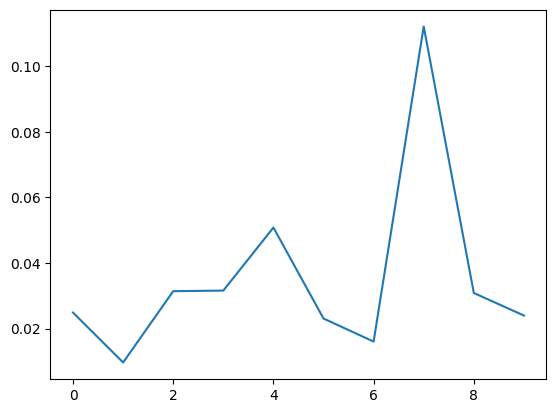

In [9]:
losses = []
epochs = []
def train_model(model, optimizer, data_loader, loss_module, num_epochs=1000):
  model.train()
  with open('./plots/cause_id_{}.txt'.format(cause_id), 'w') as f:
    for epoch in range(num_epochs):
      epochs.append(epoch)
      for data_point, data_label in data_loader:
        data_point = data_point.to(device)
        data_label = data_label.to(device)
        data_label = data_label.squeeze(dim=1)

        output = model(data_point)
        output = output.squeeze(dim=1)

        # print(f"Predicted: {output} - True value: {data_label}")

        loss = loss_module(output, data_label.float())
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      losses.append(loss.item())
      output = f"Epoch {epoch} loss: {loss.item()}"
      print(output)
      #print(output, file = f)

train_model(model, optimizer, train_data_loader, loss_func, num_epochs=10)

# Plotting the loss
plt.plot(epochs, losses)
#plt.xlabel('Epochs')
#plt.ylabel('Loss')


#plt.savefig('./plots/cause_id_{}.png'.format(cause_id))



In [10]:
# Plot the correlation matrix of the dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = dataset.data.numpy().T
corr = np.corrcoef(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('./plots/cause_id_{}_corr.png'.format(cause_id))

# Plot the correlation matrix of the dataset
plt.show()

AttributeError: 'Tensor' object has no attribute 'corr'